## code for back-extracting a timeseries of co2 flux from hindcast201905
## comparison of back-extracted flux from hindcast 2015 to model-output extracted flux from BR3-2015

### Summary:

- as written right now, backcalculated and model-output air-sea flux is *not directly comparable*
- the backcalculation dramatically increases air-sea flux; this may be due to slightly different parameterization - did not do a thorough analysis
- used the same pco2 flux module from matlab that I helped Jurleys with a few months ago; didn't translate mocsy's pco2 flux from fortran
- year 2015 outgassed less than any other year, from a quick analysis; pattern is robust


#### differences in methods:

- hindcast: use mean pco2 calculated from mean T,S,DIC,TA, using a python translation of a matlab co2 script 
- hindcast: use mean daily winds
- hindcast: different parameterization - this one uses 
        K=is the transfer velocity according to Wanninkhof (1992).
        #a = CO2 solibility constant according to Weiss (1974)
- differences are large. in general this hindcast backcalculation makes abs. magnitude of flux (both in and out) larger

- weiss seems slightly different in mocsy? - do not see inversion term in matlab:  
      mocsy:
      tk    = ptmp + 273.15d0
      invtk = 1.0d0 / tk
      tmp = (9345.17d0*invtk) - 60.2409d0 + (23.3585d0 * LOG(tk/100.0d0))
      K0 = EXP( tmp + saln*(0.023517d0 - (0.00023656d0*tk) + (0.0047036e-4_wp*tk*tk)) )
      
      matlab:
      def Ko_weiss(T,S):
        A=[-60.2409, 93.4517, 23.3585];  #mol/Kg.atm
        B=[0.023517, -0.023656, 0.0047036]; #mol/Kg.atm
        T=T+273.15; #Conversio from Celsius degrees to Kelvins
        Ln_Ko=A[0]+(A[1]*(100/T))+(A[2]*np.log(T/100))+S*(B[0]+(B[1]*(T/100))+(B[2]*(T/100)**2));
        Ko=np.exp(Ln_Ko);

#### shows maps of differences between hindcast201905-backcalculated and BR3-modeloutputed flux 
- for a given day where we also have BR3 data in this case 20150201 

#### I compared differences for multiple days (change 'ymd')


In [82]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [83]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [84]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [85]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt
import pickle

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

#import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
#from matplotlib import reload
import arrow
import gsw
%matplotlib inline

import xarray as xr
from datetime import datetime
from salishsea_tools import grid_tools, viz_tools

from math import log10, floor
import pytz

## TJŠJ translation of quick co2 flux matlab script
#### https://www.mathworks.com/matlabcentral/fileexchange/50190-air-sea-co2-flux
#### NOT identical to mocsy parameterization > did only limited delving to find out where they are different


- this has two modes - wind < 6 m/s, wind > 6 m/s
- subdivided as FCO2_lowwind and FCO2_highwind


In [86]:
def FCO2(pCO2_agua, pCO2_atm,T,S,u):
   
    ##Function for the calculation or air-sea CO2 flux
        #   copyright @ 2015 Cecilia Chapa-Balcorta

        #INPUT
    
   #pCO2_agua= seawater pCO2 (uatm)
   #pCO2_atm=  atmospheric pCO2 (uatm)
   #T=  Temperature (Celsius)
   #S=  Salinity 
   #u = Wind speed (m/s)

   #Air-sea CO2 is calculated as follows:
   
           # FCO2 =K*a(dpCO2) 
    
    #Where
    #K=is the transfer velocity according to Wanninkhof (1992).
    #a = CO2 solibility constant according to Weiss (1974)
    #dpCO2 is the difference of air and seawater pCO2 
    
    
    ##### CO2 Transfer velocity calculation #########
       
    Sc=Schmidt(T);
    if u<=6:
        K=0.31*(u**2)*((Sc/660)**-0.5); #for slower steadier wind
    #K=K*3600*24;  #conversion to   m/day
    else:    
        K=0.39*(u**2)*((Sc/660)**-0.5);


    dpCO2=pCO2_agua-pCO2_atm;     ##calculation of delta pCO2
    a=Ko_weiss(T,S);    #Solibility in mmol L^-1 atm^-1 or mmol m^-3 uatm^-1
    
    F_CO2 =0.24*K*a*dpCO2; #CO2 flux (mmol m^-2 d^-1)
    
    return  F_CO2, dpCO2

#####Subrutines #################################################

#****Solibuility constant (Weiss, 1974) ***********************************

def Ko_weiss(T,S):
#
    A=[-60.2409, 93.4517, 23.3585];  #mol/Kg.atm
    B=[0.023517, -0.023656, 0.0047036]; #mol/Kg.atm
    T=T+273.15; #Conversio from Celsius degrees to Kelvins
    Ln_Ko=A[0]+(A[1]*(100/T))+(A[2]*np.log(T/100))+S*(B[0]+(B[1]*(T/100))+(B[2]*(T/100)**2));
    Ko=np.exp(Ln_Ko);

    return Ko

#******** Schmidt Number*********

    #For water of salinity=35 and temperature range 0-30∞C    #############

def Schmidt(T):
    
    A = 2073.1;     B = 125.62;     C = 3.6276;     D = 0.043219;
    Sc= A - (B*T)+(C*T**2)-(D*T**3);
    
    return Sc
    


def FCO2_lowwind(pCO2_agua, pCO2_atm,T,S,u):
   
    ##Function for the calculation or air-sea CO2 flux
        #same as above, but only u<6
    
    ##### CO2 Transfer velocity calculation #########
       
    Sc=Schmidt(T);
    #assumption, u <6
    K=0.31*(u**2)*((Sc/660)**-0.5); #for slower steadier wind
    #K=K*3600*24;  #conversion to   m/day
    #else:    

    dpCO2=pCO2_agua-pCO2_atm;     ##calculation of delta pCO2
    a=Ko_weiss(T,S);    #Solibility in mmol L^-1 atm^-1 or mmol m^-3 uatm^-1
    
    F_CO2 =0.24*K*a*dpCO2; #CO2 flux (mmol m^-2 d^-1)
    
    return  F_CO2, dpCO2

def FCO2_highwind(pCO2_agua, pCO2_atm,T,S,u):
   
    ##Function for the calculation or air-sea CO2 flux
        #same as above, but only u<6
    
    ##### CO2 Transfer velocity calculation #########
       
    Sc=Schmidt(T);
    #assumption, u >=6
    K=0.39*(u**2)*((Sc/660)**-0.5); #for slower steadier wind
    #K=K*3600*24;  #conversion to   m/day
    #else:    

    dpCO2=pCO2_agua-pCO2_atm;     ##calculation of delta pCO2
    a=Ko_weiss(T,S);    #Solibility in mmol L^-1 atm^-1 or mmol m^-3 uatm^-1
    
    F_CO2 =0.24*K*a*dpCO2; #CO2 flux (mmol m^-2 d^-1)
    
    return  F_CO2, dpCO2



## find and plot atmospheric pCO2 vs time for 2008-2015 (to put into co2 flux calculation)

In [87]:
start ='2008-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)


arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)

dayslen = len(arrow_array)
atcco2_array = np.zeros(dayslen)
dec_time_array = np.zeros(dayslen)


#constants from SKOG

LR_slope   =  2.149     #  linear regression + gaussian fit
LR_int     =  -3929.359 #  to seasonal cycle of atmospheric co2
ctr        =  161.898   #  based on scripps observations at ptbarrow and lajolla
amp        =  7.083     #  calc notebook by TJSJ
wid        =  44.703    #  notebook loc:
ctr2       =  218.832   #  carbon_dev/MOCSY_and_FLUX/CO2_obs.ipynb
amp2       =  -19.004   #
wid2       =  87.8836   #
ctr3       =  199.430   #
amp3       =  8.026     #
wid3       =  -185.920  #

zz_LRslop = LR_slope
zz_LRint = LR_int
zz_ctr = ctr
zz_ctr2 = ctr2
zz_ctr3 = ctr3
zz_wid = wid
zz_wid2 = wid2
zz_wid3 = wid3
zz_amp = amp
zz_amp2 = amp2
zz_amp3 = amp3

for i in range(0,len(arrow_array)):

    tdate = arrow_array[i][0]
    ymd = tdate.format('YYYYMMDD')
    doy = tdate.format('DDDD')
    yr = tdate.format('YYYY')
    
    zz_year = int(yr)
    zz_day = int(doy)

    zz_yearcyc =  zz_amp * np.exp( -((zz_day - zz_ctr)/zz_wid)**2)\
      + zz_amp2 * np.exp( -((zz_day - zz_ctr2)/zz_wid2)**2)\
      + zz_amp3 * np.exp( -((zz_day - zz_ctr3)/zz_wid3)**2)

    zz_atcco2 = (zz_year+(zz_day/365))*zz_LRslop+zz_LRint + zz_yearcyc
    atcco2_array[i] = zz_atcco2
    dec_time_array[i] = zz_year+(zz_day/365)

Text(0, 0.5, 'uatm co2 ')

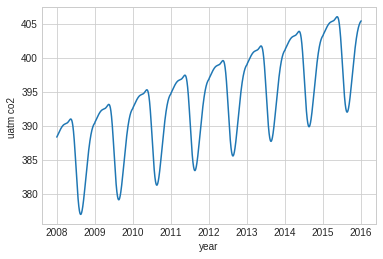

In [88]:
plt.plot(dec_time_array,atcco2_array)
plt.xlabel('year')
plt.ylabel('uatm co2 ')


## using this alg to calculate air-sea flux for day 20150201  from hindcast 
## also extract model-calculated co2 flux for the same day (for BR3) and compare
## also look at differences between carbon content for the two model days - it's small
- we see that the backcalculated estimate results in far larger outgassing - flux, in any direction, is larger

## comparison - day 20150901

mean co2flx - hincast
-1.6247126
mean co2flx - br3
-0.3386100526642471
nanmean surface value - hindcast
1874.4363
nanmean surface value - BR3
1860.7102


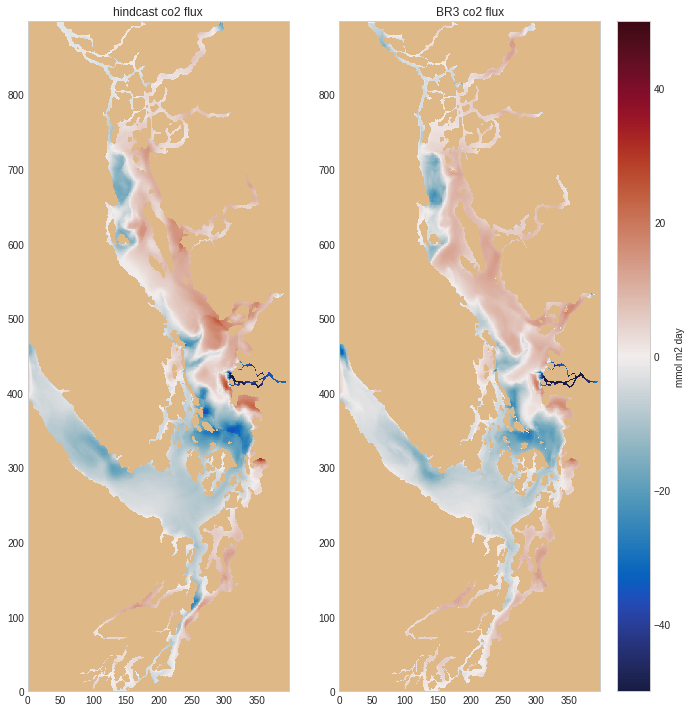

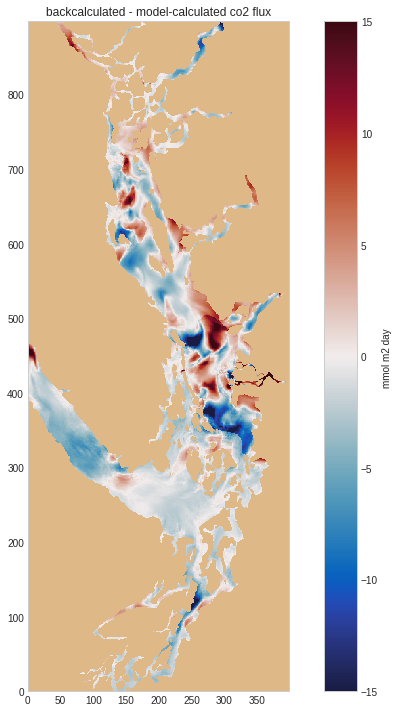

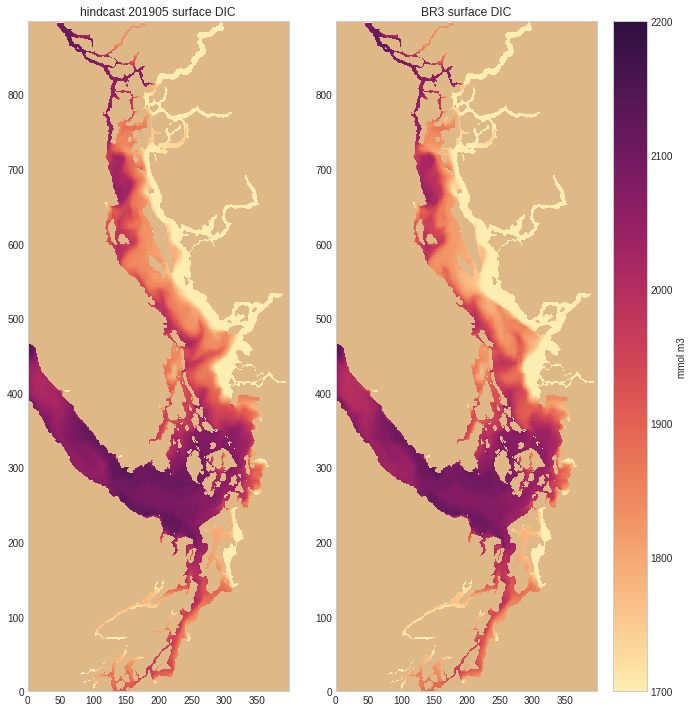

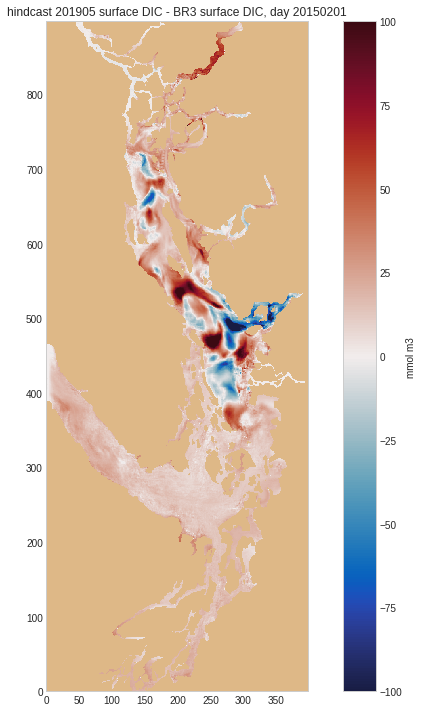

In [89]:
ymd = '20150901'

# STEP calculate co2 flux using this algorithm 
for i in range(0,1):

   
    t_grid = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_DIC-TA-T-S/grid_1d_'+ymd+'.nc')
    t_pco2 = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_OmA-pH-pCO2/OmA_plus_'+ymd+'.nc')
    t_wind = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
    
    temp = np.ravel(t_grid['model_output']['TEMP'][0,:,:])
    sal = np.ravel(t_grid['model_output']['SAL'][0,:,:])
    pco2 = np.ravel(t_pco2['model_output']['pCO2'][:,:])
    wind = np.ravel(t_wind['model_output']['wind_mag'][:,:])
    tzero = np.zeros_like(wind)
    pCO2_atm = np.zeros_like(wind)
    pCO2_atm[:] = atcco2_array[i]
    #2 algs for calculating fco2, high and low
    F_CO2_high_alg = np.zeros_like(wind)
    F_CO2_low_alg = np.zeros_like(wind)
    F_CO2 = np.zeros_like(wind)
    
    tsra_psu = sal*35/35.16504
    ttera_is = gsw.t_from_CT(sal,temp,tzero)
    
    F_CO2_high_alg, dpCO2 =  FCO2_highwind(pco2, pCO2_atm,temp,sal,wind)
    F_CO2_low_alg, dpCO2 =  FCO2_lowwind(pco2, pCO2_atm,temp,sal,wind)
    
    lowwind = np.where(wind<6)
    land = np.where(np.ma.is_masked(temp))
    
    F_CO2_high_alg[lowwind] = F_CO2_low_alg[lowwind]
    #F_CO2_high_alg[land] = np.nan
    
    F_CO2_high_alg_r = F_CO2_high_alg.reshape(898,398)
    F_CO2_high_alg_r[F_CO2_high_alg_r>1e5] = np.nan
    F_CO2_high_alg_r = -1*F_CO2_high_alg_r

    
###STEP openning co2 flux from BR3
w = (glob.glob('/data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG_1d_*_carp_T_' + ymd + '*.nc'))


fromBR_20150201 = nc.Dataset(w[0])
#convert to daily
fco2_fromBR_20150201 = (fromBR_20150201['co2_flux_mmol_m2_s'][0,:,:]*86400)

##STEP plot the two fluxes
fco2_backcalc_20150201 = F_CO2_high_alg_r

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 10))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(fco2_backcalc_20150201[:,:], cmap=cm.cm.balance, vmin = -50, vmax = 50)
viz_tools.plot_land_mask(ax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax.set_title('hindcast co2 flux')

viz_tools.set_aspect(ax2)
mesh2 = ax2.pcolormesh(fco2_fromBR_20150201[:,:], cmap=cm.cm.balance, vmin = -50, vmax = 50)
viz_tools.plot_land_mask(ax2, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax2.set_title('BR3 co2 flux')
cbar = plt.colorbar(mesh, label ='mmol m2 day')

plt.tight_layout()

print('mean co2flx - hincast')
print(np.nanmean(fco2_backcalc_20150201[:,:]))
print('mean co2flx - br3')
print(np.nanmean(fco2_fromBR_20150201[:,:]))


fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(fco2_backcalc_20150201[:,:]-(fco2_fromBR_20150201[:,:]), \
                     cmap=cm.cm.balance, vmin = -15, vmax = 15)
viz_tools.plot_land_mask(ax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
cbar = plt.colorbar(mesh, label = 'mmol m2 day ')
ax.set_title('backcalculated - model-calculated co2 flux')


plt.tight_layout()

# STEP plot surface DIC

t_carp = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_DIC-TA-T-S/carp_1d_'+ymd+'.nc')

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 10))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(t_carp['model_output']['DIC'][0,:,:], cmap=cm.cm.matter, vmin = 1700, vmax = 2200)
viz_tools.plot_land_mask(ax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax.set_title('hindcast 201905 surface DIC')

viz_tools.set_aspect(ax2)
mesh2 = ax2.pcolormesh(fromBR_20150201['dissolved_inorganic_carbon'][0,0,:,:], \
                       cmap=cm.cm.matter, vmin = 1700, vmax = 2200)
viz_tools.plot_land_mask(ax2, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax2.set_title('BR3 surface DIC')
cbar = plt.colorbar(mesh, label ='mmol m3')

plt.tight_layout()

t_carp = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_DIC-TA-T-S/carp_1d_'+ymd+'.nc')

fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(t_carp['model_output']['DIC'][0,:,:]-fromBR_20150201['dissolved_inorganic_carbon'][0,0,:,:],\
                     cmap=cm.cm.balance, vmin = -100, vmax = 100)
viz_tools.plot_land_mask(ax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax.set_title('hindcast 201905 surface DIC - BR3 surface DIC, day 20150201')

cbar = plt.colorbar(mesh, label ='mmol m3')

plt.tight_layout()

print('nanmean surface value - hindcast')
h_DIC = t_carp['model_output']['DIC'][0,:,:]
h_DIC[h_DIC == 0] = np.nan
print(np.nanmean(h_DIC))
print('nanmean surface value - BR3')
b3_DIC = fromBR_20150201['dissolved_inorganic_carbon'][0,0,:,:]
b3_DIC[b3_DIC == 0] = np.nan
print(np.nanmean(b3_DIC))


## comparison -day 20150201

mean co2flx - hincast
-5.8619843
mean co2flx - br3
-1.8254240034245874
nanmean surface value - hindcast
1832.7722
nanmean surface value - BR3
1833.5042


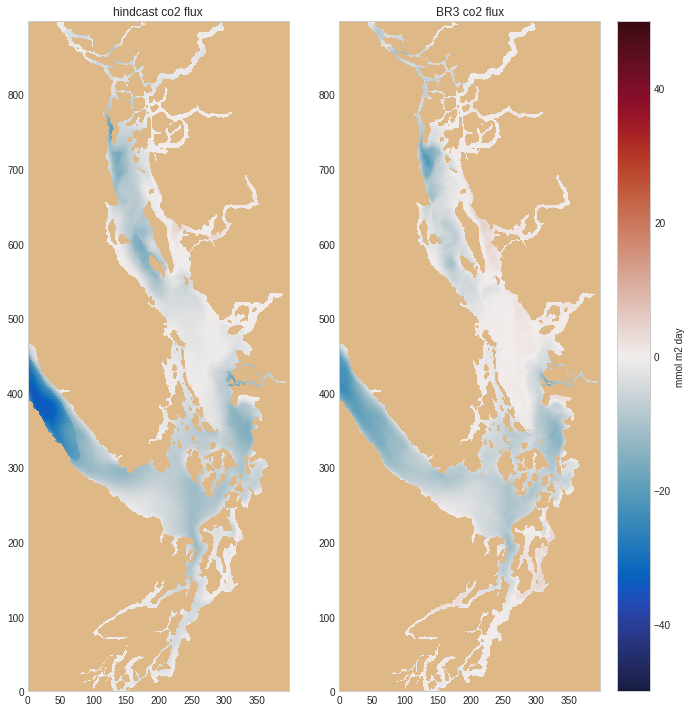

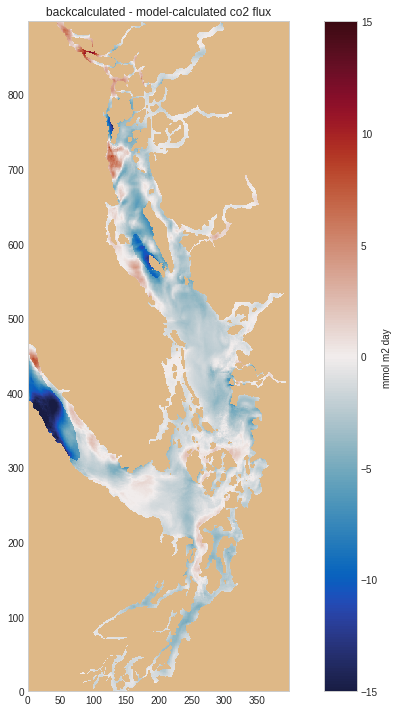

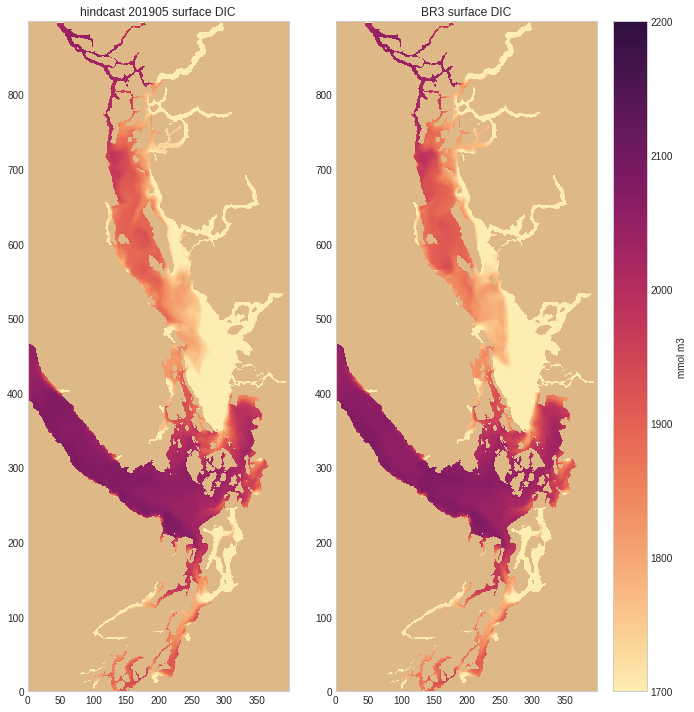

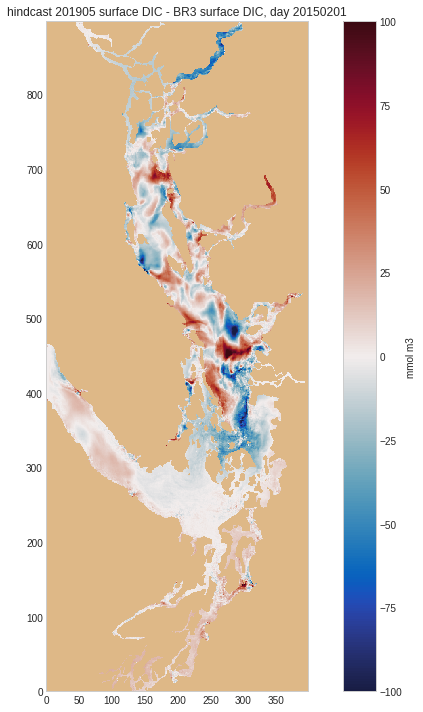

In [90]:
ymd = '20150201'

# STEP calculate co2 flux using this algorithm 
for i in range(0,1):

   
    t_grid = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_DIC-TA-T-S/grid_1d_'+ymd+'.nc')
    t_pco2 = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_OmA-pH-pCO2/OmA_plus_'+ymd+'.nc')
    t_wind = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
    
    temp = np.ravel(t_grid['model_output']['TEMP'][0,:,:])
    sal = np.ravel(t_grid['model_output']['SAL'][0,:,:])
    pco2 = np.ravel(t_pco2['model_output']['pCO2'][:,:])
    wind = np.ravel(t_wind['model_output']['wind_mag'][:,:])
    tzero = np.zeros_like(wind)
    pCO2_atm = np.zeros_like(wind)
    pCO2_atm[:] = atcco2_array[i]
    #2 algs for calculating fco2, high and low
    F_CO2_high_alg = np.zeros_like(wind)
    F_CO2_low_alg = np.zeros_like(wind)
    F_CO2 = np.zeros_like(wind)
    
    tsra_psu = sal*35/35.16504
    ttera_is = gsw.t_from_CT(sal,temp,tzero)
    
    F_CO2_high_alg, dpCO2 =  FCO2_highwind(pco2, pCO2_atm,temp,sal,wind)
    F_CO2_low_alg, dpCO2 =  FCO2_lowwind(pco2, pCO2_atm,temp,sal,wind)
    
    lowwind = np.where(wind<6)
    land = np.where(np.ma.is_masked(temp))
    
    F_CO2_high_alg[lowwind] = F_CO2_low_alg[lowwind]
    #F_CO2_high_alg[land] = np.nan
    
    F_CO2_high_alg_r = F_CO2_high_alg.reshape(898,398)
    F_CO2_high_alg_r[F_CO2_high_alg_r>1e5] = np.nan
    F_CO2_high_alg_r = -1*F_CO2_high_alg_r

    
###STEP openning co2 flux from BR3
w = (glob.glob('/data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/SKOG_1d_*_carp_T_' + ymd + '*.nc'))


fromBR_20150201 = nc.Dataset(w[0])
#convert to daily
fco2_fromBR_20150201 = (fromBR_20150201['co2_flux_mmol_m2_s'][0,:,:]*86400)

##STEP plot the two fluxes
fco2_backcalc_20150201 = F_CO2_high_alg_r

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 10))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(fco2_backcalc_20150201[:,:], cmap=cm.cm.balance, vmin = -50, vmax = 50)
viz_tools.plot_land_mask(ax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax.set_title('hindcast co2 flux')

viz_tools.set_aspect(ax2)
mesh2 = ax2.pcolormesh(fco2_fromBR_20150201[:,:], cmap=cm.cm.balance, vmin = -50, vmax = 50)
viz_tools.plot_land_mask(ax2, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax2.set_title('BR3 co2 flux')
cbar = plt.colorbar(mesh, label ='mmol m2 day')

plt.tight_layout()

print('mean co2flx - hincast')
print(np.nanmean(fco2_backcalc_20150201[:,:]))
print('mean co2flx - br3')
print(np.nanmean(fco2_fromBR_20150201[:,:]))


fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(fco2_backcalc_20150201[:,:]-(fco2_fromBR_20150201[:,:]), \
                     cmap=cm.cm.balance, vmin = -15, vmax = 15)
viz_tools.plot_land_mask(ax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
cbar = plt.colorbar(mesh, label = 'mmol m2 day ')
ax.set_title('backcalculated - model-calculated co2 flux')


plt.tight_layout()

# STEP plot surface DIC

t_carp = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_DIC-TA-T-S/carp_1d_'+ymd+'.nc')

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 10))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(t_carp['model_output']['DIC'][0,:,:], cmap=cm.cm.matter, vmin = 1700, vmax = 2200)
viz_tools.plot_land_mask(ax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax.set_title('hindcast 201905 surface DIC')

viz_tools.set_aspect(ax2)
mesh2 = ax2.pcolormesh(fromBR_20150201['dissolved_inorganic_carbon'][0,0,:,:], \
                       cmap=cm.cm.matter, vmin = 1700, vmax = 2200)
viz_tools.plot_land_mask(ax2, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax2.set_title('BR3 surface DIC')
cbar = plt.colorbar(mesh, label ='mmol m3')

plt.tight_layout()

t_carp = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_DIC-TA-T-S/carp_1d_'+ymd+'.nc')

fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(t_carp['model_output']['DIC'][0,:,:]-fromBR_20150201['dissolved_inorganic_carbon'][0,0,:,:],\
                     cmap=cm.cm.balance, vmin = -100, vmax = 100)
viz_tools.plot_land_mask(ax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc', color = 'burlywood')
ax.set_title('hindcast 201905 surface DIC - BR3 surface DIC, day 20150201')

cbar = plt.colorbar(mesh, label ='mmol m3')

plt.tight_layout()

print('nanmean surface value - hindcast')
h_DIC = t_carp['model_output']['DIC'][0,:,:]
h_DIC[h_DIC == 0] = np.nan
print(np.nanmean(h_DIC))
print('nanmean surface value - BR3')
b3_DIC = fromBR_20150201['dissolved_inorganic_carbon'][0,0,:,:]
b3_DIC[b3_DIC == 0] = np.nan
print(np.nanmean(b3_DIC))


## code to get daily co2 flux fields for hindcast, 2008-2015 (currently commented out)

In [91]:
# start_run = arrow.get(start)
# end_run = arrow.get(end)


# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)

# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')



#     if i%50 == 0:
#         print(ymd)
#     t_grid = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_DIC-TA-T-S/grid_1d_'+ymd+'.nc')
#     t_pco2 = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_OmA-pH-pCO2/OmA_plus_'+ymd+'.nc')
#     t_wind = nc.Dataset('/data/tjarniko/results/hindcast.201905_windmag_interp/windmag_interp_1d_'+ymd+'.nc')
    
#     temp = np.ravel(t_grid['model_output']['TEMP'][0,:,:])
#     sal = np.ravel(t_grid['model_output']['SAL'][0,:,:])
#     pco2 = np.ravel(t_pco2['model_output']['pCO2'][:,:])
#     wind = np.ravel(t_wind['model_output']['wind_mag'][:,:])
#     tzero = np.zeros_like(wind)
#     pCO2_atm = np.zeros_like(wind)
#     pCO2_atm[:] = atcco2_array[i]
#     #2 algs for calculating fco2, high and low
#     F_CO2_high_alg = np.zeros_like(wind)
#     F_CO2_low_alg = np.zeros_like(wind)
#     F_CO2 = np.zeros_like(wind)
    
#     tsra_psu = sal*35/35.16504
#     ttera_is = gsw.t_from_CT(sal,temp,tzero)
    
#     F_CO2_high_alg, dpCO2 =  FCO2_highwind(pco2, pCO2_atm,temp,sal,wind)
#     F_CO2_low_alg, dpCO2 =  FCO2_lowwind(pco2, pCO2_atm,temp,sal,wind)
    
#     lowwind = np.where(wind<6)
#     land = np.where(np.ma.is_masked(temp))
    
#     F_CO2_high_alg[lowwind] = F_CO2_low_alg[lowwind]
#     #F_CO2_high_alg[land] = np.nan
    
#     F_CO2_high_alg_r = F_CO2_high_alg.reshape(898,398)
#     F_CO2_high_alg_r[F_CO2_high_alg_r>1e5] = np.nan
#     F_CO2_high_alg_out_neg = -1*F_CO2_high_alg_r
    
#     fn = 'co2flux' + ymd + '.nc'
#     tdir = '/data/tjarniko/results/hindcast.201905_co2flux/'
#     ncname = tdir + fn

#     f = nc.Dataset(ncname,'w', format='NETCDF4') #'w' stands for write
#     g = f.createGroup('model_output')
#     g.createDimension('ydir',898)
#     g.createDimension('xdir',398)

#     ts = g.createVariable('CO2flux_mmol_m2_day','f4',('ydir','xdir'))
#     ts[:] = F_CO2_high_alg_out_neg[:,:]


In [92]:
# start_run = arrow.get('2008-01-01')
# end_run = arrow.get('2008-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)

# dayslen = len(arrow_array)
# print(dayslen)

# if len(arrow_array) == 366:
#     arrow_array.pop(59)
    
# dayslen = len(arrow_array)
# print(dayslen)
    
# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2008_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2009-01-01')
# end_run = arrow.get('2009-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2009_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2010-01-01')
# end_run = arrow.get('2010-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2010_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2011-01-01')
# end_run = arrow.get('2011-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2011_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2012-01-01')
# end_run = arrow.get('2012-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# dayslen = len(arrow_array)
# print(dayslen)

# if len(arrow_array) == 366:
#     arrow_array.pop(59)
    
# dayslen = len(arrow_array)
# print(dayslen)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2012_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2013-01-01')
# end_run = arrow.get('2013-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2013_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2014-01-01')
# end_run = arrow.get('2014-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2014_co2_flx.pkl", 'wb'))

# start_run = arrow.get('2015-01-01')
# end_run = arrow.get('2015-12-31')

# co2_flx = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)
# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')
#     co2_flx[i] = np.nanmean(t_flx['model_output']['CO2flux_mmol_m2_day'][:])
    
# pickle.dump(co2_flx, open("hindcast2015_co2_flx.pkl", 'wb'))

## visualizing an 8-year timeseries of mean air-sea fluxes

In [93]:
t_flx = nc.Dataset('/data/tjarniko/results/hindcast.201905_co2flux/co2flux'+ymd+'.nc')


In [94]:
hindcast2008_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2008_co2_flx.pkl', 'rb'))  
hindcast2009_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2009_co2_flx.pkl', 'rb'))  
hindcast2010_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2010_co2_flx.pkl', 'rb'))  
hindcast2011_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2011_co2_flx.pkl', 'rb'))  
hindcast2012_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2012_co2_flx.pkl', 'rb'))  
hindcast2013_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2013_co2_flx.pkl', 'rb'))  
hindcast2014_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2014_co2_flx.pkl', 'rb'))  
hindcast2015_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/hindcast2015_co2_flx.pkl', 'rb'))  

Text(0.5, 0, 'days')

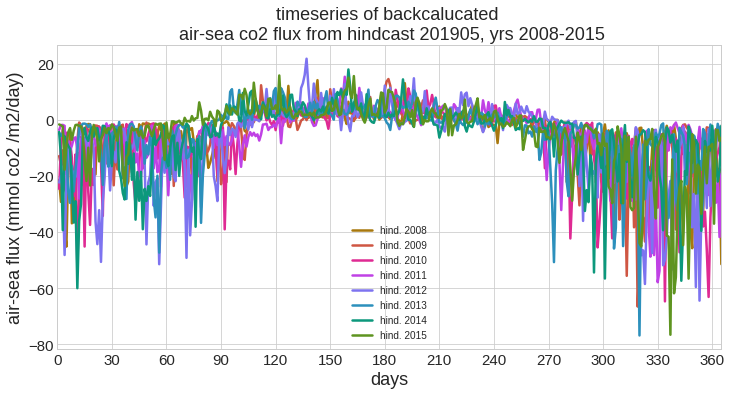

In [95]:
hindcast2008_co2_flx

days = np.arange(1,366,1)
tcm = cm.cm.phase

fs = 18
fact = 0.7
fig = plt.figure(figsize=(17*fact,8*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)

#months
ax1.plot(days,hindcast2008_co2_flx, \
         color = tcm(1.*0/8),linewidth = lw, linestyle = '-', label = 'hind. 2008')
ax1.plot(days,hindcast2009_co2_flx, \
         color = tcm(1.*1/8),linewidth = lw, linestyle = '-', label = 'hind. 2009')
ax1.plot(days,hindcast2010_co2_flx, \
         color = tcm(1.*2/8),linewidth = lw, linestyle = '-', label = 'hind. 2010')
ax1.plot(days,hindcast2011_co2_flx, \
         color = tcm(1.*3/8),linewidth = lw, linestyle = '-', label = 'hind. 2011')
ax1.plot(days,hindcast2012_co2_flx, \
         color = tcm(1.*4/8),linewidth = lw, linestyle = '-', label = 'hind. 2012')
ax1.plot(days,hindcast2013_co2_flx, \
         color = tcm(1.*5/8),linewidth = lw, linestyle = '-', label = 'hind. 2013')
ax1.plot(days,hindcast2014_co2_flx, \
         color = tcm(1.*6/8),linewidth = lw, linestyle = '-', label = 'hind. 2014')
ax1.plot(days,hindcast2015_co2_flx, \
         color = tcm(1.*7/8),linewidth = lw, linestyle = '-', label = 'hind. 2015')




ax1.tick_params(axis='both', which='major', labelsize=15)
#ax1.legend(bbox_to_anchor=[1, 1], fontsize = fs-4.5)
ax1.legend(loc = 'best')
w = ax1.set_xticks(np.arange(0, 365, step=30))
ax1.set_xlim(0,365)
#w = ax1.set_yticks(np.arange(0, 110, step=10))
ax1.set_ylabel('air-sea flux (mmol co2 /m2/day)', fontsize = 18)
ax1.set_title('timeseries of backcalucated \n air-sea co2 flux from hindcast 201905, yrs 2008-2015', fontsize = 18)
ax1.set_xlabel('days', fontsize = 18)

## Calculate mean daily air-sea flux (mmol/m2/day) in 2015 from BR3, compare to 2015 from hindcast201905

In [96]:
# start = '2015-01-01'
# end = '2015-12-31'
# start_run = arrow.get(start)
# end_run = arrow.get(end)

# mean_br3_asflux = np.zeros(365)

# arrow_array = []
# for r in arrow.Arrow.span_range('day', start_run, end_run):
#     arrow_array.append(r)

# dayslen = len(arrow_array)

# for i in range(0,dayslen):

#     tdate = arrow_array[i][0]
#     ymd = tdate.format('YYYYMMDD')
#     if i%50 == 0:
#         print(ymd)
#     tnc = glob.glob('/data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/'\
#                         'SKOG*carp*'+ymd+'*.nc')
#     t_carp = nc.Dataset(tnc[0])
#     co2 = t_carp['co2_flux_mmol_m2_s'][0,:,:]
#     ## mean 
#     co2_mean_mmol_m2_day = np.nanmean(co2) * 86400
#     mean_br3_asflux[i] = co2_mean_mmol_m2_day
    
# pickle.dump(mean_br3_asflux, open("./pkls_hindcast201905_airseaflux/BR3_2015_co2_flx.pkl", 'wb'))

In [97]:
BR3_2015_co2_flx = pickle.load(open('./pkls_hindcast201905_airseaflux/BR3_2015_co2_flx.pkl', 'rb'))  

Text(0.5, 0, 'days')

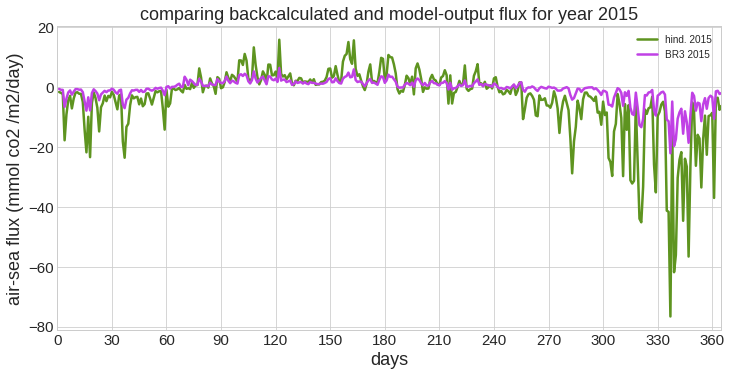

In [98]:
hindcast2008_co2_flx

days = np.arange(1,366,1)
tcm = cm.cm.phase

fs = 18
fact = 0.7
fig = plt.figure(figsize=(17*fact,8*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)

#months

ax1.plot(days,hindcast2015_co2_flx, \
         color = tcm(1.*7/8),linewidth = lw, linestyle = '-', label = 'hind. 2015')
ax1.plot(days,BR3_2015_co2_flx, \
         color = tcm(1.*3/8),linewidth = lw, linestyle = '-', label = 'BR3 2015')




ax1.tick_params(axis='both', which='major', labelsize=15)
#ax1.legend(bbox_to_anchor=[1, 1], fontsize = fs-4.5)
ax1.legend(loc = 'best')
w = ax1.set_xticks(np.arange(0, 365, step=30))
ax1.set_xlim(0,365)
#w = ax1.set_yticks(np.arange(0, 110, step=10))
ax1.set_ylabel('air-sea flux (mmol co2 /m2/day)', fontsize = 18)
ax1.set_title('comparing backcalculated and model-output flux for year 2015', fontsize = 18)
ax1.set_xlabel('days', fontsize = 18)

Text(0.5, 0, 'year')

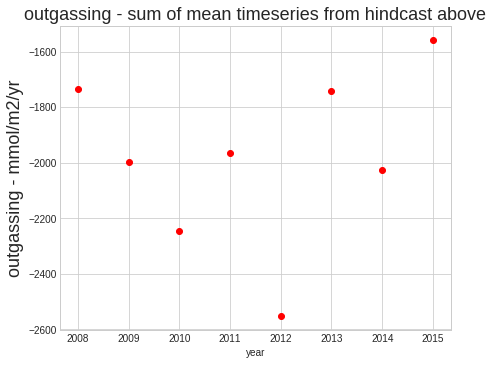

In [99]:
hind08_yr = np.sum(hindcast2008_co2_flx)
hind09_yr = np.sum(hindcast2009_co2_flx)
hind10_yr = np.sum(hindcast2010_co2_flx)
hind11_yr = np.sum(hindcast2011_co2_flx)
hind12_yr = np.sum(hindcast2012_co2_flx)
hind13_yr = np.sum(hindcast2013_co2_flx)
hind14_yr = np.sum(hindcast2014_co2_flx)
hind15_yr = np.sum(hindcast2015_co2_flx)

yrs = np.arange(2008,2016,1)
hindsums = [hind08_yr,hind09_yr,hind10_yr,hind11_yr,hind12_yr,\
            hind13_yr,hind14_yr,hind15_yr]


hindcast2008_co2_flx

days = np.arange(1,366,1)
tcm = cm.cm.phase

fs = 18
fact = 0.7
fig = plt.figure(figsize=(10*fact,8*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)

#months

ax1.plot(yrs,hindsums,'ro')

ax1.set_title('outgassing - sum of mean timeseries from hindcast above', fontsize = 18)
ax1.set_ylabel('outgassing - mmol/m2/yr', fontsize = 18)
ax1.set_xlabel('year')

In [100]:
np.shape(yrs)

(8,)